### Initialize

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

from rdkit import rdBase
rdBase.DisableLog('rdApp.*')

In [83]:
from rdkit import Chem
import os
import glob
import pickle
from tqdm import tqdm
from collections import defaultdict
from itertools import chain, repeat
import sys

sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from constants import dataset_params, ec_encoder
from analysis.metrics import BasicMolecularMetrics, MoleculeProperties
from analysis.docking import calculate_qvina2_score, smina_score

pd.set_option('display.float_format', lambda x: '%.3f' % x)

RANDOM_SEED = 1

In [84]:
dataset_info = dataset_params['bindingmoad']
smiles_list = np.load('./processed_noH_ca/train_smiles.npy')
BASIC_METRICS = BasicMolecularMetrics(dataset_info, smiles_list)
MOL_METRICS = MoleculeProperties()

with open('./processed_noH_ca/ec_dict.pickle', 'rb') as f:
    ec_dict = pickle.load(f)
    
EC_LEVEL = 1
EC_ENCODER = ec_encoder[EC_LEVEL]

### Test-set Property

In [6]:
test_dir = './processed_noH_ca/test'
test_sdf = list(glob.glob(f'{test_dir}/[!.]*.sdf'))
vina_csv = './processed_noH_ca/test_qvina/vina_scores.csv'

In [7]:
test_mols_dict = defaultdict(list)

for file in test_sdf:
    ligand_name = file.split('/')[-1]
    test_mols_dict[ligand_name] += list(Chem.SDMolSupplier(str(file), sanitize=False))

In [86]:
from rdkit.Chem.rdMolDescriptors import CalcNumRings
from rdkit.Chem.Descriptors import MolWt

def evaluate_molecules(mols_dict, vina_csv=None, 
                       validity_file=None, time_file=None,
                       organize_by_ec=False):
    assert all([k[-3:]=='sdf' for k in mols_dict.keys()])
    
    df = defaultdict(list)
    
    # basic molecular metrics
    (validity, connectivity, uniqueness, novelty), _ = BASIC_METRICS.evaluate_rdmols(list(chain.from_iterable(mols_dict.values())))
        
    # vina score
    if vina_csv is not None:
        vina_scores_dict = {}
        with open(vina_csv, 'r') as f:
            for i, row in enumerate(f.readlines()):
                if i==0: continue
                row = row.split('\t')
                ligand = row[1]
                try:
                    vina_scores_dict[ligand] = [s if s<0 else 0 for s in eval(row[2])]
                    if all([int(s) == 0 for s in vina_scores_dict[ligand]]):
                        raise NameError
                except NameError:
                    vina_scores_dict[ligand] = [None] * (1 + row[2].count(','))
                    
    # generation validity
    if validity_file is not None: 
        with open(validity_file, 'r') as f:
            validity_dict = {}
            for line in f.readlines():
                ligand, validity = line.split(' ')
                ligand = line.split(' ')[0].split('/')[-1].replace('.sdf', '_gen.sdf')
                validity_dict[ligand] = float(validity)
                
    # generation time
    if time_file is not None:   
        with open(time_file, 'r') as f:
            time_dict = {}
            for line in f.readlines():
                ligand, validity = line.split(' ')
                ligand = line.split(' ')[0].split('/')[-1].replace('.sdf', '_gen.sdf')
                time_dict[ligand] = float(validity)
    
    for ligand, mols in tqdm(mols_dict.items()):
        # indices needed to be checked for filtering the list of vina scores
        valid_idc = [BASIC_METRICS.check_valid_and_connected(mol) for mol in mols]
        connected_mols = [mol for i, mol in enumerate(mols) if valid_idc[i]]
        
        receptor = ligand[:4]
        n_mols = len(connected_mols)
        
        if organize_by_ec:
            ec_list = ec_dict[receptor]
            if len(ec_list) == 0: continue
            ec = '.'.join(ec_list[0].split('.')[:EC_LEVEL])
            df['ec'] += list(repeat(ec, n_mols))
            
        df['receptor'] += list(repeat(receptor, n_mols))
        df['mols'] += connected_mols
        
        if validity_file is not None:
            df['validity'] += list(repeat(validity_dict[ligand] * len(connected_mols) / len(mols), n_mols))
        else:
            df['validity'] += list(repeat(validity, n_mols))
        
        df['connectivity'] += list(repeat(connectivity, n_mols))
        df['uniqueness'] += list(repeat(uniqueness, n_mols))
        df['novelty'] += list(repeat(novelty, n_mols))
        
        if time_file is not None:
            df['time'] += list(repeat(time_dict[ligand], n_mols))
        
        # chemical molecular properties
        df['qed'] += [MOL_METRICS.calculate_qed(mol) for mol in connected_mols]
        df['sa'] += [MOL_METRICS.calculate_sa(mol) for mol in connected_mols]
        df['logp'] += [MOL_METRICS.calculate_logp(mol) for mol in connected_mols]
        df['lipinski'] += [MOL_METRICS.calculate_lipinski(mol) for mol in connected_mols]
        df['diversity'] += list(repeat(MOL_METRICS.calculate_diversity(connected_mols), n_mols))
        
        df['MW'] += [MolWt(mol) for mol in connected_mols]
        df['size'] += [mol.GetNumAtoms() for mol in connected_mols]
        df['n_rings'] += [CalcNumRings(mol) for mol in connected_mols]
        
        if vina_csv is not None:
            vina_scores = [s for i, s in enumerate(vina_scores_dict[ligand]) if valid_idc[i]]
            df['vina_scores'] += vina_scores

    df = pd.DataFrame(df)
    
    return df

In [9]:
df_test = evaluate_molecules(test_mols_dict, vina_csv, organize_by_ec=False)
df_test['group'] = 'test' 
df_test

Validity over 413 molecules: 96.61%
Connectivity over 399 valid molecules: 100.00%
Uniqueness over 399 connected molecules: 93.48%
Novelty over 373 unique connected molecules: 100.00%


100%|██████████| 413/413 [00:01<00:00, 239.53it/s]


,receptor,mols,validity,connectivity,uniqueness,novelty,qed,sa,logp,lipinski,diversity,MW,size,n_rings,vina_scores,group
0,6TC1,<rdkit.Chem.rdchem.Mol object at 0x2afd41a4e260>,0.966,1.000,0.935,1.000,0.536,0.490,0.256,5,0.000,122.132,8,1,NaN,test
1,3VEV,<rdkit.Chem.rdchem.Mol object at 0x2afd41a4e320>,0.966,1.000,0.935,1.000,0.782,0.320,0.837,5,0.000,371.233,28,3,NaN,test
2,5HRW,<rdkit.Chem.rdchem.Mol object at 0x2afd41a4e380>,0.966,1.000,0.935,1.000,0.676,0.410,0.499,5,0.000,216.155,17,3,-8.600,test
3,5J6N,<rdkit.Chem.rdchem.Mol object at 0x2afd41a4e3e0>,0.966,1.000,0.935,1.000,0.670,0.370,1.065,5,0.000,403.286,29,3,-9.200,test
4,2XXR,<rdkit.Chem.rdchem.Mol object at 0x2afd41a4e440>,0.966,1.000,0.935,1.000,0.480,0.530,-1.336,5,0.000,138.058,10,0,-6.500,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,2VYT,<rdkit.Chem.rdchem.Mol object at 0x2afd41a3fbe0>,0.966,1.000,0.935,1.000,0.439,0.400,-1.023,5,0.000,144.089,11,0,-4.200,test
395,4JXH,<rdkit.Chem.rdchem.Mol object at 0x2afd41a3fc40>,0.966,1.000,0.935,1.000,0.825,0.320,0.929,5,0.000,262.225,19,2,-6.900,test
396,4I12,<rdkit.Chem.rdchem.Mol object at 0x2afd41a3fd00>,0.966,1.000,0.935,1.000,0.585,0.270,2.688,5,0.000,491.858,36,5,-8.700,test
397,4B2D,<rdkit.Chem.rdchem.Mol object at 0x2afd41a3fd60>,0.966,1.000,0.935,1.000,0.436,0.520,-0.987,5,0.000,98.037,7,0,-3.600,test


In [10]:
test_summary = df_test.describe()
test_summary.to_csv(f'{test_dir}/summary.csv')
test_summary

,validity,connectivity,uniqueness,novelty,qed,sa,logp,lipinski,diversity,MW,size,n_rings,vina_scores
count,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,268.000
mean,0.966,1.000,0.935,1.000,0.586,0.366,0.536,4.950,0.000,266.301,19.539,2.183,-7.642
std,0.000,0.000,0.000,0.000,0.123,0.091,1.242,0.230,0.000,117.584,8.836,1.582,2.330
min,0.966,1.000,0.935,1.000,0.290,0.130,-2.164,3.000,0.000,54.028,4.000,0.000,-15.500
25%,0.966,1.000,0.935,1.000,0.488,0.300,-0.326,5.000,0.000,165.264,12.000,1.000,-9.300
50%,0.966,1.000,0.935,1.000,0.587,0.360,0.479,5.000,0.000,254.141,19.000,2.000,-7.600
75%,0.966,1.000,0.935,1.000,0.679,0.420,1.328,5.000,0.000,353.264,26.000,3.000,-5.800
max,0.966,1.000,0.935,1.000,0.867,0.760,4.589,5.000,0.000,716.518,54.000,8.000,-3.000


<AxesSubplot:xlabel='qed', ylabel='Density'>

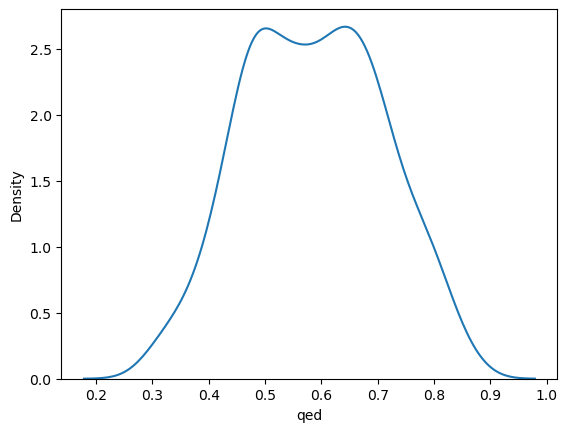

In [69]:
# plt.hist(df_test['qed'], width=0.05, density=True)
sns.kdeplot(df_test, x='qed')

In [ ]:
# plt.hist(df_test['sa'], width=0.05, density=True)
sns.kdeplot(df_test, x='sa')

In [ ]:
# plt.hist(df_test['logp'], width=0.5, density=True)
sns.kdeplot(df_test, x='logp')

In [ ]:
# plt.hist(df_test['vina_scores'], width=1, density=True)
sns.kdeplot(df_test, x='vina_scores')

### EC number

In [11]:
df_test_ec = evaluate_molecules(test_mols_dict, vina_csv, organize_by_ec=True)
df_test_ec

Validity over 413 molecules: 96.61%
Connectivity over 399 valid molecules: 100.00%
Uniqueness over 399 connected molecules: 93.48%
Novelty over 373 unique connected molecules: 100.00%


100%|██████████| 413/413 [00:00<00:00, 539.70it/s]


,ec,receptor,mols,validity,connectivity,uniqueness,novelty,qed,sa,logp,lipinski,diversity,MW,size,n_rings,vina_scores
0,3,6TC1,<rdkit.Chem.rdchem.Mol object at 0x2afd41a4e260>,0.966,1.000,0.935,1.000,0.536,0.490,0.256,5,0.000,122.132,8,1,NaN
1,2,3VEV,<rdkit.Chem.rdchem.Mol object at 0x2afd41a4e320>,0.966,1.000,0.935,1.000,0.782,0.320,0.837,5,0.000,371.233,28,3,NaN
2,3,5J6N,<rdkit.Chem.rdchem.Mol object at 0x2afd41a4e3e0>,0.966,1.000,0.935,1.000,0.670,0.370,1.065,5,0.000,403.286,29,3,-9.200
3,2,6F71,<rdkit.Chem.rdchem.Mol object at 0x2afd41a4e4a0>,0.966,1.000,0.935,1.000,0.786,0.350,2.156,5,0.000,260.160,20,3,-9.300
4,3,6EY8,<rdkit.Chem.rdchem.Mol object at 0x2afd41a4e500>,0.966,1.000,0.935,1.000,0.620,0.290,3.468,5,0.000,385.725,29,4,-10.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,1,6BH4,<rdkit.Chem.rdchem.Mol object at 0x2afd41a3fa60>,0.966,1.000,0.935,1.000,0.793,0.370,-0.089,5,0.000,304.228,24,3,-10.400
291,2,6QR6,<rdkit.Chem.rdchem.Mol object at 0x2afd41a3fac0>,0.966,1.000,0.935,1.000,0.687,0.270,1.980,5,0.000,372.306,30,5,-10.200
292,1,5G6J,<rdkit.Chem.rdchem.Mol object at 0x2afd41a3fb20>,0.966,1.000,0.935,1.000,0.684,0.260,1.221,5,0.000,286.229,23,3,-9.600
293,3,4I12,<rdkit.Chem.rdchem.Mol object at 0x2afd41a3fd00>,0.966,1.000,0.935,1.000,0.585,0.270,2.688,5,0.000,491.858,36,5,-8.700


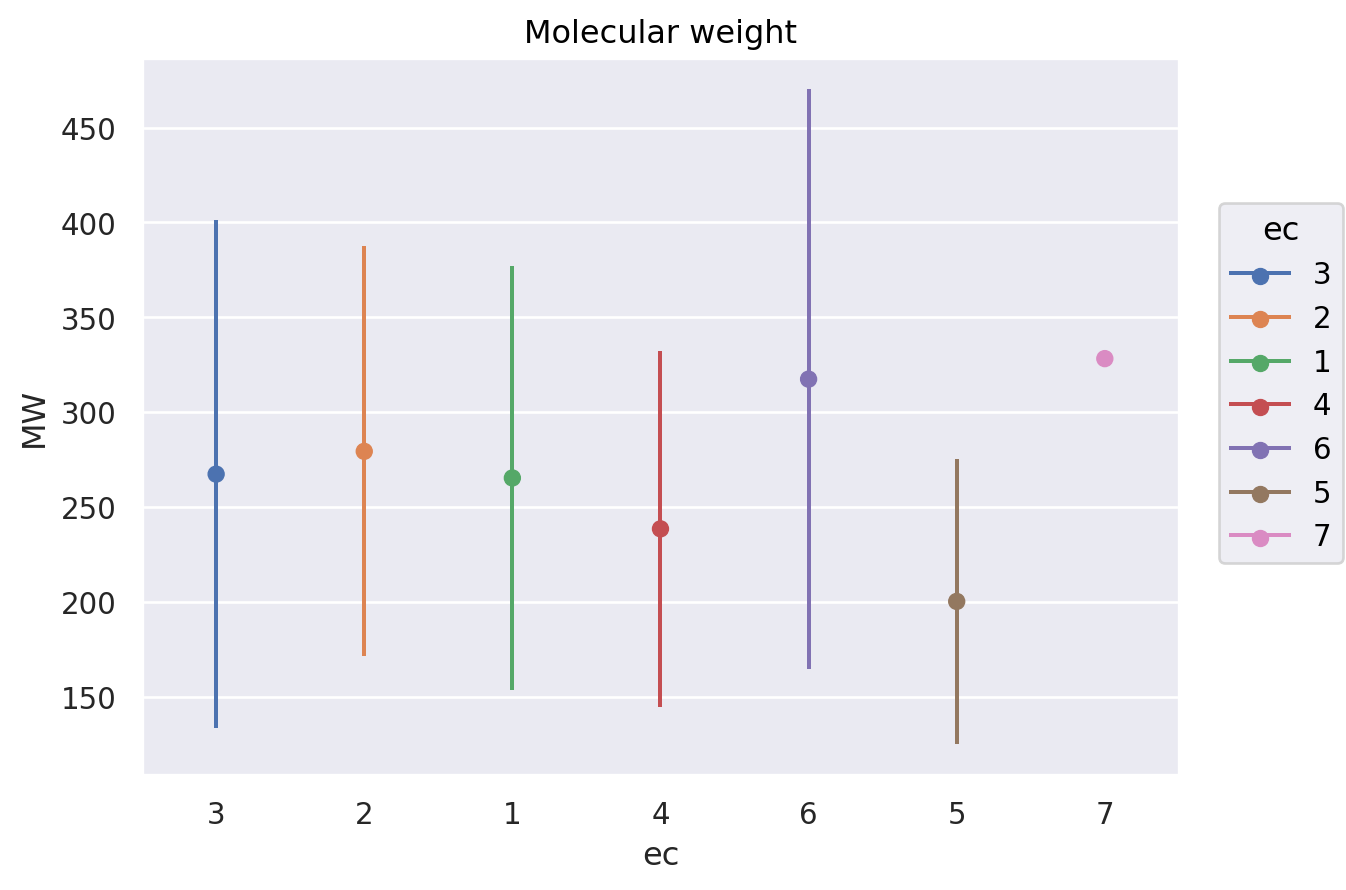

In [76]:
import seaborn.objects as so

p = so.Plot(df_test_ec, x='ec', y='MW', color='ec').add(so.Range(),so.Est(errorbar="sd")).add(so.Dot(), so.Agg())
p.label(title="Molecular weight")

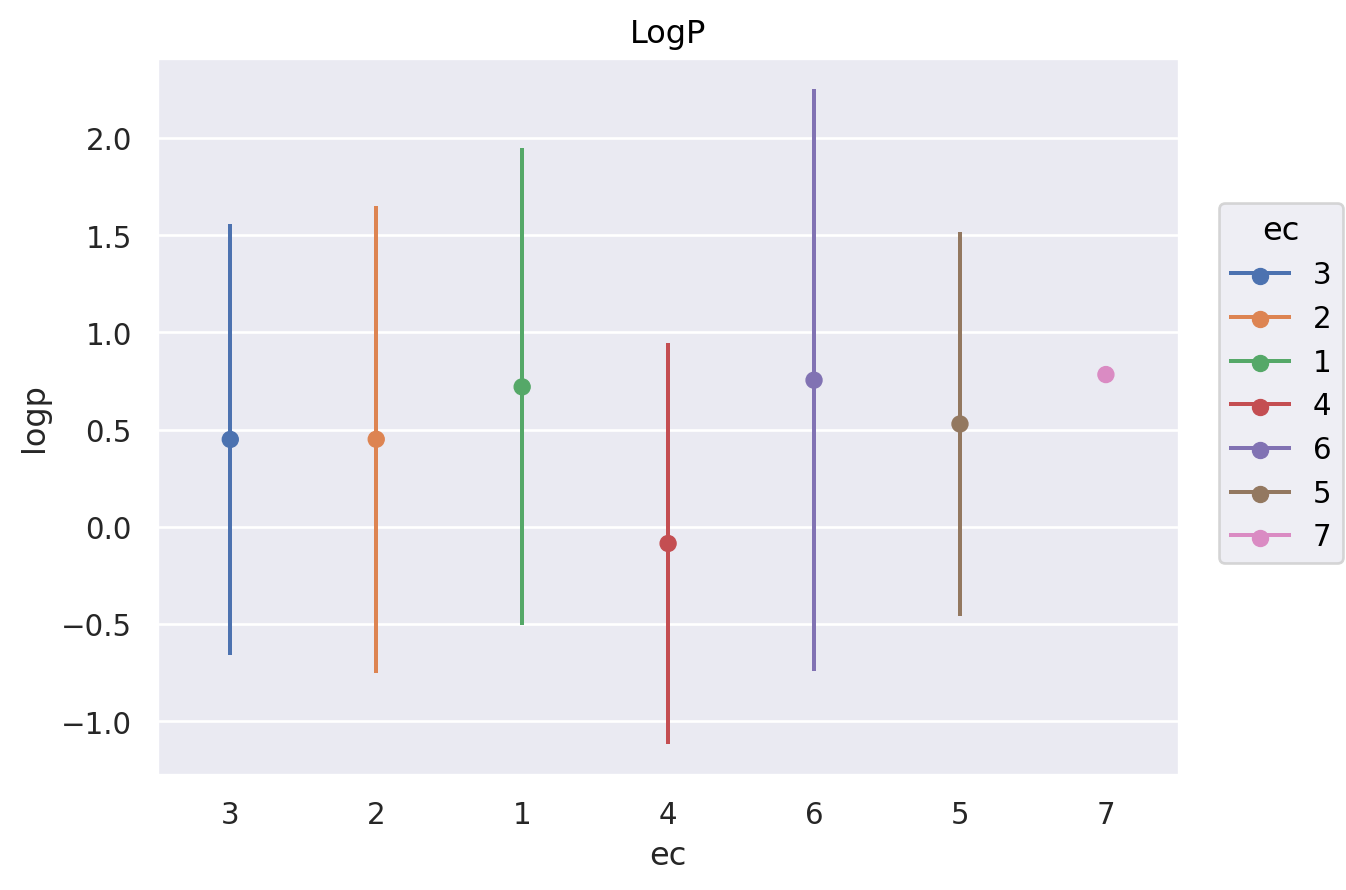

In [77]:
p = so.Plot(df_test_ec, x='ec', y='logp', color='ec').add(so.Range(),so.Est(errorbar="sd")).add(so.Dot(), so.Agg())
p.label(title="LogP")

In [16]:
df_test_ec.groupby('ec')['receptor'].count()

ec
1    73
2    90
3    80
4    27
5    13
6    11
7     1
Name: receptor, dtype: int64

In [73]:
from rdkit import DataStructs
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect, GetMACCSKeysFingerprint

def get_similarity_map(df, subset=-1, criterion='MACCS', 
                       similarity_map_name='similarity_map',
                       similarity_std_name='similarity_std'):
    assert 'ec', 'mols' in df.columns
    
    fp_dict = defaultdict(list)
    n_classes = len(EC_ENCODER)
    similarity_map = pd.DataFrame(np.zeros((n_classes, n_classes)),
                                  index=sorted(EC_ENCODER.keys()), columns=sorted(EC_ENCODER.keys()))
    similarity_std = pd.DataFrame(np.zeros((n_classes, n_classes)),
                                  index=sorted(EC_ENCODER.keys()), columns=sorted(EC_ENCODER.keys()))
    
    for i, row in df.iterrows():
        if criterion == 'MACCS':
            fp_dict[row['ec']].append(GetMACCSKeysFingerprint(row['mols']))
        elif criterion == 'Morgan':
            fp_dict[row['ec']].append(GetMorganFingerprintAsBitVect(row['mols'], radius=2, nBits=1024))
        else:
            raise NotImplementedError
            
    if subset > 0:
        tmp = {}
        for k, v in fp_dict.items():
            if len(v) >= subset: 
                random_idc = np.random.choice(len(v), replace=False, size=subset, seed=RANDOM_SEED)
            else:
                random_idc = np.concatenate([
                    np.tile(np.arange(len(v)), subset//len(v)),
                    np.random.choice(len(v), replace=False, size=subset%len(v), seed=RANDOM_SEED)
                ])
            tmp[k] = [v[i] for i in random_idc]
        fp_dict = tmp

    for k1, li1 in fp_dict.items():
        for k2, li2 in fp_dict.items():
            tanimoto_scores = [DataStructs.TanimotoSimilarity(m, n) 
                               for i, m in enumerate(li1) for j, n in enumerate(li2)
                               if k1 != k2 or i != j]
            similarity_map.loc[k1, k2] = np.mean(tanimoto_scores)
            similarity_std.loc[k1, k2] = np.std(tanimoto_scores)
            
    similarity_map.name = similarity_map_name
    similarity_std.name = similarity_std_name
            
    return similarity_map, similarity_std

def visualize_heatmap(df_mean, df_std=None, save_dir=None, **kwargs):
        
    if save_dir is not None:
        df_mean.to_csv(os.path.join(save_dir, f'{df_mean.name}.csv'))
        if df_std is not None:
            df_std.to_csv(os.path.join(save_dir, f'{df_std.name}.csv'))
    
    if df_std is not None:
        plt.figure(figsize=(7, 6))
        annotations = df_mean.map('{:.2f}'.format).astype(str) + '\n±' + df_std.map('{:.2f}'.format).astype(str)
        s = sns.heatmap(df_mean, annot=annotations, vmin=0, vmax=1, cmap='Spectral', fmt = '')
        s.set(xlabel='EC', ylabel='EC', **kwargs)
    else:
        plt.figure(figsize=(6, 5))
        s = sns.heatmap(df_mean, annot=True, vmin=0, vmax=1, cmap='Spectral')
        s.set(xlabel='EC', ylabel='EC', **kwargs)
        
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, df_mean.name))
        plt.clf()
    else:
        plt.show()
            

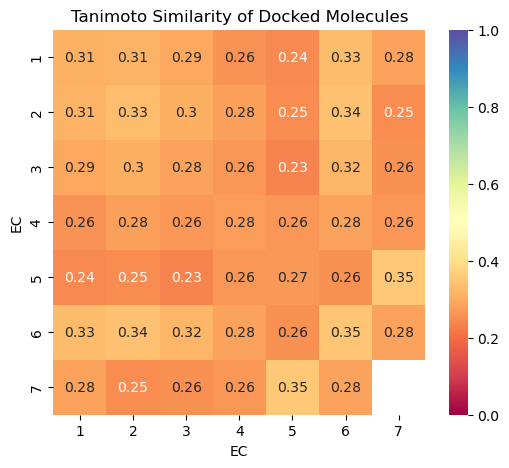

In [19]:
test_similarity, _ = get_similarity_map(df_test_ec)
visualize_heatmap(test_similarity, title='Tanimoto Similarity of Docked Molecules')

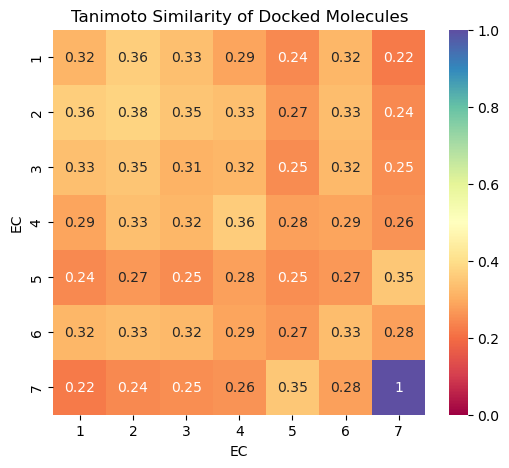

In [27]:
test_similarity, _ = get_similarity_map(df_test_ec, subset=10)
visualize_heatmap(test_similarity, title='Tanimoto Similarity of Docked Molecules')

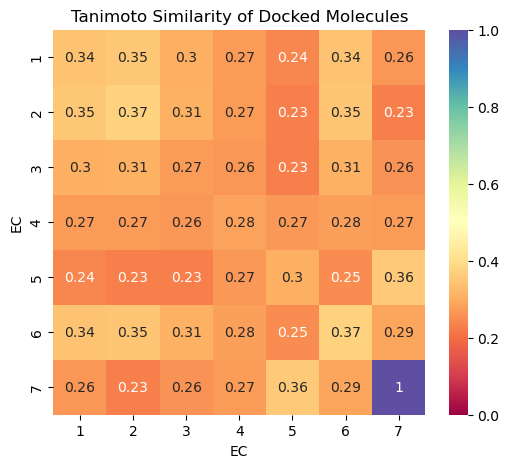

In [75]:
test_similarity, _ = get_similarity_map(df_test_ec, subset=25)
visualize_heatmap(test_similarity, title='Tanimoto Similarity of Docked Molecules')

### Train set

In [49]:
train_npz = './processed_noH_ca/train.npz'

with np.load(train_npz, allow_pickle=True) as f:
    train_data = {key: val for key, val in f.items()}
    
train_data.keys()

dict_keys(['names', 'receptors', 'lig_coords', 'lig_one_hot', 'lig_mask', 'pocket_coords', 'pocket_one_hot', 'pocket_mask', 'labels'])

In [50]:
del train_data

### Analyze samples

In [87]:
def get_sample_df(out_dir, group, desc, vina=True, organize_by_ec=False, save_summary=True):
    
    sample_dir = os.path.join(out_dir, group)
    
    sample_sdf = list(glob.glob(f'{sample_dir}/generated/[!.]*.sdf'))
    qvina_csv = f'{sample_dir}/qvina/vina_scores.csv' if vina else None 
    validity_file = f'{sample_dir}/pocket_validities.txt'
    time_file = f'{sample_dir}/pocket_times.txt'
    
    mols_dict = defaultdict(list)
    for file in sample_sdf:
        ligand_name = file.split('/')[-1]
        mols_dict[ligand_name] += list(Chem.SDMolSupplier(str(file), sanitize=False))
        
    df_sample = evaluate_molecules(mols_dict, qvina_csv, 
                                   validity_file, time_file,
                                   organize_by_ec=organize_by_ec)
    df_sample['group'] = desc
    df_sample['sample_dir'] = sample_dir
    
    if save_summary:
        df_sample.describe().to_csv(f'{sample_dir}/summary.csv')
    
    return df_sample

In [88]:
def plot_kde(df, keys, division='group', save_file=None, **kwargs):
    assert division in df.columns
    
    fig, axes = plt.subplots(len(keys), 1, figsize = (6, 5*len(keys)))
    groups = df[division].unique()
    
    for i in range(len(keys)):
        for group in groups:
            p = sns.kdeplot(df[df[division]==group], x=keys[i], ax=axes[i], label=group, **kwargs)
        p.set_ylabel('density')
        p.legend(fontsize=5)
    
    plt.tight_layout()
    if save_file is not None:
        fig.savefig(save_file)           
        plt.clf()

In [89]:
from datetime import datetime

def pipeline1(out_dir, groups, descriptions, vina=True):
    
    df_samples = [df_test]
    for group, desc in zip(groups, descriptions):
        df_samples.append(get_sample_df(out_dir, group, desc))
    
    df_samples = pd.concat(df_samples, ignore_index=True)
    
    keys = ['vina_scores', 'qed', 'sa', 'logp'] if vina else ['qed', 'sa', 'logp']
    plot_kde(df_samples, keys, save_file=f'{out_dir}/{datetime.now()}_{len(groups)}_groups_kde.png', alpha=0.5)
        
    return df_samples

In [ ]:
groups = [
    'or_j_ca_h1_v1_ep500',
    'add_j_ca_h1_v1_ep500',
    'cat_j_ca_h1_v1_ep500',
    'cf_add_j_ca_h1_v1_ep500',
    'cf_cat_j_ca_h1_v1_ep500',
    'clf_add_j_ca_h1_v1_ep500',
    'clf_cat_j_ca_h1_v1_ep500',
]
descriptions = [
    'original model',
    'context(add) model',
    'context(concat) model',
    'classifier-free(add) model',
    'classifier-free(concat) model',
    'classifier-guidance(add) model',
    'classifier-guidance(concat) model',
]
out_dir = './outputs'

df_samples = pipeline1(out_dir, groups, descriptions)

Validity over 10275 molecules: 98.06%
Connectivity over 10076 valid molecules: 100.00%
Uniqueness over 10076 connected molecules: 94.56%
Novelty over 9528 unique connected molecules: 98.45%


100%|██████████| 411/411 [02:03<00:00,  3.34it/s]


Validity over 10275 molecules: 99.34%
Connectivity over 10207 valid molecules: 100.00%
Uniqueness over 10207 connected molecules: 92.98%
Novelty over 9490 unique connected molecules: 98.84%


100%|██████████| 411/411 [02:04<00:00,  3.29it/s]


Validity over 10275 molecules: 99.48%
Connectivity over 10222 valid molecules: 100.00%
Uniqueness over 10222 connected molecules: 97.28%
Novelty over 9944 unique connected molecules: 98.92%


 99%|█████████▉| 406/411 [05:36<00:04,  1.21it/s]

In [42]:
import seaborn.objects as so

def pipeline2(out_dir, groups, descriptions, vina=True):
    
    df_samples = []
    for group, desc in zip(groups, descriptions):
        df_sample = get_sample_df(out_dir, group, desc, organize_by_ec=True)
        df_samples.append(df_sample)
        sample_dir = os.path.join(out_dir, group)
        
        similarity_map, _ = get_similarity_map(df_sample)
        visualize_heatmap(similarity_map, title='Tanimoto Similarity of Generated Molecules', save_dir=sample_dir)
        
        p = so.Plot(df_sample, x='ec', color='ec').pair(y=['MW', 'logp']).add(so.Range(),so.Est(errorbar="sd")).add(so.Dot(), so.Agg())
        p.save(os.path.join(sample_dir, 'MW_logp_errorplot.png'))
        
    df_samples = pd.concat(df_samples, ignore_index=True)
        
    return df_samples

In [47]:
groups = [
    'or_j_ca_h1_v1_ep500',
    'add_j_ca_h1_v1_ep500',
    'cat_j_ca_h1_v1_ep500',
    'cf_add_j_ca_h1_v1_ep500',
    'cf_cat_j_ca_h1_v1_ep500',
    'clf_add_j_ca_h1_v1_ep500',
    'clf_cat_j_ca_h1_v1_ep500',
]
descriptions = [
    'original model',
    'context(add) model',
    'context(concat) model',
    'classifier-free(add) model',
    'classifier-free(concat) model',
    'classifier-guidance(add) model',
    'classifier-guidance(concat) model',
]
out_dir = './outputs'

df_samples = pipeline2(out_dir, groups, descriptions)

Validity over 10275 molecules: 98.06%
Connectivity over 10076 valid molecules: 100.00%
Uniqueness over 10076 connected molecules: 94.56%
Novelty over 9528 unique connected molecules: 98.45%


100%|██████████| 411/411 [01:32<00:00,  4.44it/s]


Validity over 10275 molecules: 99.34%
Connectivity over 10207 valid molecules: 100.00%
Uniqueness over 10207 connected molecules: 92.98%
Novelty over 9490 unique connected molecules: 98.84%


100%|██████████| 411/411 [01:34<00:00,  4.33it/s]


Validity over 10275 molecules: 99.48%
Connectivity over 10222 valid molecules: 100.00%
Uniqueness over 10222 connected molecules: 97.28%
Novelty over 9944 unique connected molecules: 98.92%


100%|██████████| 411/411 [04:28<00:00,  1.53it/s]


Validity over 10275 molecules: 98.90%
Connectivity over 10162 valid molecules: 100.00%
Uniqueness over 10162 connected molecules: 92.14%
Novelty over 9363 unique connected molecules: 98.39%


100%|██████████| 411/411 [01:35<00:00,  4.31it/s]


Validity over 10275 molecules: 96.73%
Connectivity over 9939 valid molecules: 100.00%
Uniqueness over 9939 connected molecules: 97.06%
Novelty over 9647 unique connected molecules: 98.55%


100%|██████████| 411/411 [03:00<00:00,  2.28it/s]


Validity over 10275 molecules: 99.64%
Connectivity over 10238 valid molecules: 100.00%
Uniqueness over 10238 connected molecules: 96.94%
Novelty over 9925 unique connected molecules: 98.87%


100%|██████████| 411/411 [02:18<00:00,  2.96it/s]


Validity over 10275 molecules: 98.07%
Connectivity over 10077 valid molecules: 100.00%
Uniqueness over 10077 connected molecules: 97.37%
Novelty over 9812 unique connected molecules: 98.68%


100%|██████████| 411/411 [02:44<00:00,  2.50it/s]


<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [74]:
for group in descriptions:
    df_sample = df_samples[df_samples['group']==group]
    
    similarity_map, _ = get_similarity_map(df_sample)
    visualize_heatmap(similarity_map, title='Tanimoto Similarity of Generated Molecules',
                      save_dir=df_sample['sample_dir'].iloc[0])

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [85]:
n_subset = 25

for group in descriptions:
    df_sample = df_samples[df_samples['group']==group]
    df_sub = []
    for ec in EC_ENCODER.keys():
        df_tmp = df_sample[df_sample['ec']==ec]
        df_size = df_tmp.shape[0]
        if df_size > n_subset:
            df_sub.append(df_tmp.sample(n=n_subset, random_state=RANDOM_SEED))
        else:
            df_sub.append(
                    pd.concat([df_tmp]*(n_subset//df_size)) if n_subset%df_size==0  
                    else pd.concat([df_tmp]*(n_subset//df_size)+
                                   [df_tmp.sample(n=n_subset%df_size, random_state=RANDOM_SEED)])
            )
    df_sub = pd.concat(df_sub)
    
    similarity_map, _ = get_similarity_map(df_sub, similarity_map_name='similarity_map_25_per_ec')
    visualize_heatmap(similarity_map, title='Tanimoto Similarity of Generated Molecules',
                      save_dir=df_sample['sample_dir'].iloc[0])

    p = so.Plot(df_sample, x='ec', color='ec').pair(y=['MW', 'logp']).add(so.Range(),so.Est(errorbar="sd")).add(so.Dot(), so.Agg())
    p.save(os.path.join(df_sample['sample_dir'].iloc[0], 'MW_logp_errorplot_25_per_ec.png'))

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>